In [1]:
#############################################################################################
#############################################################################################
#############################################################################################
###### Initial attempt at Covid kaggle competition...more just for funsies than anything ####
###### Author: Hayes Merritt                                                             ####
###### Date: June 05, 2021                                                               ####
#############################################################################################
#############################################################################################
#############################################################################################

In [ ]:
# Goal is to predict the total number of covid cases (and possibly the number of deaths)

In [2]:
# Import pandas and read in the data
import pandas as pd
covid_df = pd.read_csv("./archive/owid-covid-data.csv", parse_dates=['date'])
rel_nans = pd.DataFrame(covid_df.isna().sum()/covid_df.shape[0])
rel_nans.columns = ['NumNaNs']
to_drop  = rel_nans[rel_nans['NumNaNs']>0.50]

In [3]:
# Drop variables with high percentage (gt 50%) of NaNs
covid_lo_nans = covid_df.drop(columns=to_drop.T.columns.values.tolist())
print("number of variables remaining after removing those with more than 50% of their observations being NaNs is: ", covid_lo_nans.shape[1])
print("total number of variables in dataset is: ", covid_df.shape[1])

number of variables remaining after removing those with more than 50% of their observations being NaNs is:  35
total number of variables in dataset is:  59


In [4]:
# Look at dtypes
covid_lo_nans.dtypes

iso_code                                   object
continent                                  object
location                                   object
date                               datetime64[ns]
total_cases                               float64
new_cases                                 float64
new_cases_smoothed                        float64
total_deaths                              float64
new_deaths                                float64
new_deaths_smoothed                       float64
total_cases_per_million                   float64
new_cases_per_million                     float64
new_cases_smoothed_per_million            float64
total_deaths_per_million                  float64
new_deaths_per_million                    float64
new_deaths_smoothed_per_million           float64
reproduction_rate                         float64
new_tests_smoothed                        float64
new_tests_smoothed_per_thousand           float64
tests_units                                object


In [5]:
covid_lo_nans['tests_units'].unique()

array([nan, 'tests performed', 'people tested', 'units unclear',
       'samples tested'], dtype=object)

<AxesSubplot:>

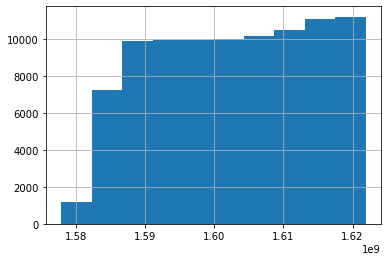

In [6]:
# Date variable should be treated as numeric/ordinal
covid_lo_nans['numeric_date'] = covid_lo_nans['date'].apply(lambda x: x.timestamp())
covid_lo_nans['numeric_date'].hist()                                                                 # check the new variable to ensure that it was performed correctly

In [ ]:
# Reduce dimensionality via correlated feature removal and/or possible target encoding.

In [7]:
# convert objects to category type
dic = {'iso_code':'category',
       'continent':'category',
       'location':'category',
       'tests_units':'category'}
covid_lo_nans = covid_lo_nans.astype(dic)

In [18]:
# Some diagnostic stuff
import numpy as np
covid_lo_nans.describe()
np.isinf(covid_lo_nans.drop(columns=['iso_code','continent','location','tests_units'])).values.sum()
covid_lo_nans.isna().sum()
for i in covid_lo_nans.drop(columns=['iso_code','continent','location','tests_units','date','numeric_date']):
#     print(covid_lo_nans[i].max())
#     print(covid_lo_nans[i].min())
#     print(np.isinf(covid_lo_nans[i]).sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [21]:
# Impute the missing values using KNN imputation
from sklearn.impute import KNNImputer
num_neighbors = [2,5,10,15,20]        # Array of number of nearest neighbors to consider when imputing
imp_dfs       = []                    # Empty array to store imputed data to be used to determine optimal number of neighbors

for i in num_neighbors:
    imp = KNNImputer(n_neighbors=i, missing_values=np.nan)  # Needed to specify "missing_values=np.nan" - otherwise get a ValueError that was erroring out the process!
    imp_dfs.append(imp.fit_transform(to_be_imputed))

In [35]:
to_be_imputed = covid_lo_nans.drop(columns=['iso_code','continent','location','tests_units','date','numeric_date'])
print(to_be_imputed.columns)

Index(['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths',
       'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')


In [44]:
scores = []  # Initialize the scores array

for i in imp_dfs: # for all imputed datasets in the imp_dfs array
    from sklearn.preprocessing import MinMaxScaler
    scaled                = pd.DataFrame(MinMaxScaler().fit_transform(i)) # Scale the data between 0 and 1
    date_scaled           = pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(covid_lo_nans['numeric_date']))) # scale the numeric date (date in total seconds since Jan 1, 1970)
    full_scaled           = pd.concat([pd.DataFrame(scaled), covid_lo_nans[['iso_code','continent','location','tests_units']], date_scaled], axis=1)  # put the imputed and non imputed data together
    names                 = to_be_imputed.columns.values.tolist()
    names.extend(['iso_code','continent','location','tests_units','numeric_date'])  # stores variable names to list
    full_scaled.columns   = names  # set the combined data variable names
    full_scaled = pd.get_dummies(full_scaled, prefix=['iso_code','continent','location','tests_units'])
    print(len(full_scaled.columns.values.tolist()))
#     from sklearn.linear_model import LinearRegression
#     reg   = LinearRegression(n_jobs=-1) # Initialize a Linear Regressor
#     reg.fit(full_scaled.drop(columns=['total_cases']), full_scaled['total_cases']) # Fit the model to the full scaleda and imputed data
#     pred  = pd.DataFrame(reg.predict(full_scaled.drop(columns=['total_cases'])))
#     err   = pred - full_scaled['total_cases']
#     SqErr = err**2
#     mse   = SqErr.mean()
#     rmse  = np.sqrt(mse)
#     scores.append(mse)
    #     scores.append(reg.score(full_scaled.drop(columns=['total_cases']), full_scaled['total_cases']))

493
493
493
493
493


In [ ]:
scores